In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [21]:
df = pd.read_csv("bmkg.csv", index_col='Tanggal', parse_dates=True)
df.index.freq = 'D'

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5053 entries, 2011-01-01 to 2024-10-31
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Suhu         4808 non-null   float64
 1   Kelembaban   4808 non-null   float64
 2   Curah_Hujan  3478 non-null   float64
dtypes: float64(3)
memory usage: 157.9 KB


In [23]:
df.describe()

,Suhu,Kelembaban,Curah_Hujan
count,4808.000000,4808.000000,3478.000000
mean,27.362230,78.897671,1092.303910
std,1.231762,7.405878,2905.192928
min,23.100000,46.000000,0.000000
25%,26.500000,75.000000,0.000000
50%,27.300000,80.000000,2.800000
75%,28.200000,84.000000,20.600000
max,33.000000,98.000000,8888.000000


In [24]:
# Menghitung berapa kali angka 2 muncul di kolom tertentu, misalnya kolom 'nilai'
jumlah_angka_dua = (df['Curah_Hujan'] == 8888).sum()

# Menampilkan hasil
print(f'Jumlah null : {jumlah_angka_dua}')

Jumlah null : 424


In [25]:
# Mengganti nilai spesifik dengan 0 di kolom tertentu
nilai_spesifik = 8888  # Nilai yang ingin diubah
cols_to_replace = ['Curah_Hujan', 'Kelembaban', 'Suhu']  # Kolom target

for col in cols_to_replace:
    df[col] = df[col].replace(nilai_spesifik, 0)  # Mengganti nilai spesifik dengan 0

print(df)

            Suhu  Kelembaban  Curah_Hujan
Tanggal                                  
2011-01-01  25.2        89.0         22.0
2011-01-02  26.5        85.0          5.0
2011-01-03  26.8        86.0          5.0
2011-01-04  25.9        89.0         16.0
2011-01-05  26.5        85.0          0.0
...          ...         ...          ...
2024-10-27  27.5        75.0          0.0
2024-10-28  28.8        75.0          4.5
2024-10-29  28.3        75.0          0.0
2024-10-30  27.3        76.0          0.0
2024-10-31  27.7        74.0          0.0

[5053 rows x 3 columns]


In [26]:
df.describe()
#BMKG Sebelum Imputasi

,Suhu,Kelembaban,Curah_Hujan
count,4808.000000,4808.000000,3478.000000
mean,27.362230,78.897671,8.775446
std,1.231762,7.405878,19.213520
min,23.100000,46.000000,0.000000
25%,26.500000,75.000000,0.000000
50%,27.300000,80.000000,0.800000
75%,28.200000,84.000000,8.000000
max,33.000000,98.000000,200.000000


In [27]:
# Mengisi data kosong dengan mean dari masing-masing kolom
cols_to_fill = ['Curah_Hujan', 'Kelembaban', 'Suhu']  # Kolom target

for col in cols_to_fill:
    mean_value = df[col].mean()  # Menghitung mean dari kolom
    df[col] = df[col].fillna(mean_value)  # Mengisi nilai kosong dengan mean

print(df)

            Suhu  Kelembaban  Curah_Hujan
Tanggal                                  
2011-01-01  25.2        89.0         22.0
2011-01-02  26.5        85.0          5.0
2011-01-03  26.8        86.0          5.0
2011-01-04  25.9        89.0         16.0
2011-01-05  26.5        85.0          0.0
...          ...         ...          ...
2024-10-27  27.5        75.0          0.0
2024-10-28  28.8        75.0          4.5
2024-10-29  28.3        75.0          0.0
2024-10-30  27.3        76.0          0.0
2024-10-31  27.7        74.0          0.0

[5053 rows x 3 columns]


In [28]:
df.describe()
#BMKG Setelah Imputasi

,Suhu,Kelembaban,Curah_Hujan
count,5053.000000,5053.000000,5053.000000
mean,27.362230,78.897671,8.775446
std,1.201523,7.224070,15.939607
min,23.100000,46.000000,0.000000
25%,26.600000,75.000000,0.000000
50%,27.362230,79.000000,6.500000
75%,28.100000,84.000000,8.775446
max,33.000000,98.000000,200.000000


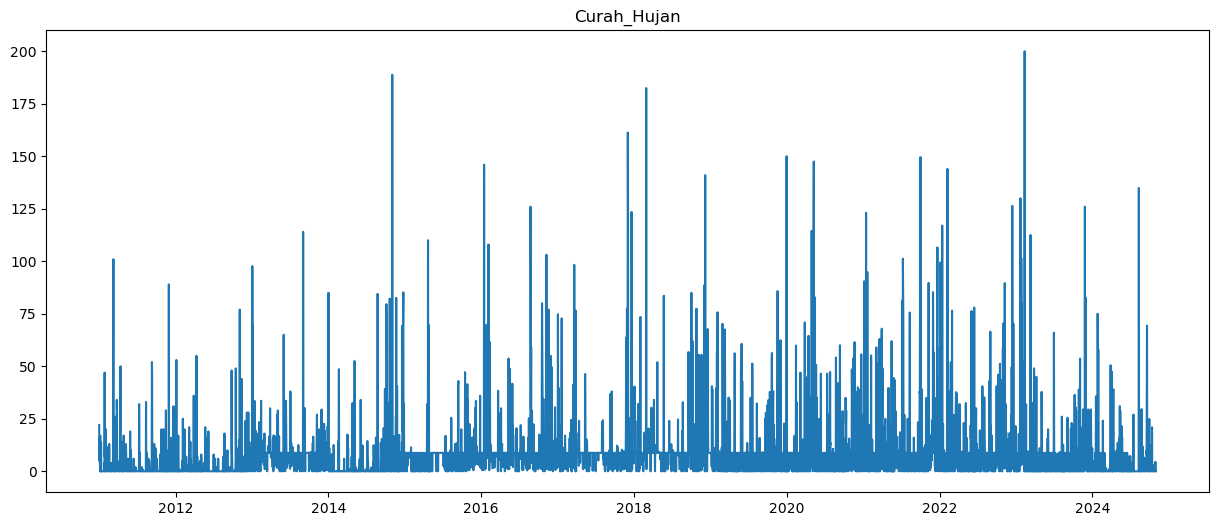

In [29]:
plt.figure(figsize=(15, 6), dpi=100)
plt.title('Curah_Hujan')
plt.plot(df['Curah_Hujan'])

In [30]:
from sklearn.preprocessing import StandardScaler
# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['Curah_Hujan']])

# === Step 3: Create Sequences for LSTM ===
sequence_length = 700  # Menggunakan 700 hari terakhir untuk memprediksi
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

# Split data (90% train, 10% test)
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [31]:
# === Step 4: Build LSTM Model ===
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer untuk satu langkah prediksi
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


C:\Users\TDMRC9\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - loss: 1.3284 - val_loss: 0.7483
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - loss: 1.0656 - val_loss: 0.7523
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 241ms/step - loss: 1.0527 - val_loss: 0.7567
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 241ms/step - loss: 0.8636 - val_loss: 0.7707
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 241ms/step - loss: 1.0946 - val_loss: 0.7513
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 248ms/step - loss: 1.0089 - val_loss: 0.7623
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 245ms/step - loss: 1.0001 - val_loss: 0.7562
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 246ms/step - loss: 1.0143 - val_loss: 0.7515
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 31s 252ms/step - loss: 1.1554 - val_loss: 0.7454
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - loss: 1.0352 - val_loss: 0.7645
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 31s 248ms/step - loss: 1.1578 - val_loss: 0.7551
Epoch 12/100
123/123

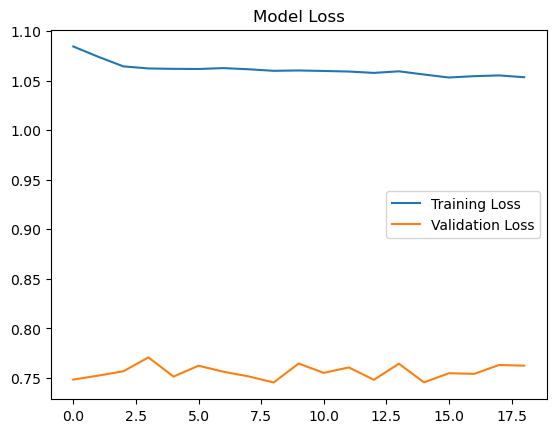

In [32]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [33]:
forecast = []
current_sequence = data_scaled[-sequence_length:].copy()  # Ambil sequence terakhir dari data

for i in range(365):
    # Prediksi langkah berikutnya
    pred = model.predict(current_sequence[np.newaxis, :, :], verbose=0)
    forecast.append(pred.flatten()[0])

    # Teacher forcing: tambahkan nilai aktual jika tersedia
    if i < len(y_test):
        current_sequence = np.append(current_sequence[1:], y_test[i]).reshape(-1, 1)
    else:
        current_sequence = np.append(current_sequence[1:], pred).reshape(-1, 1)

# Inverse scaling
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

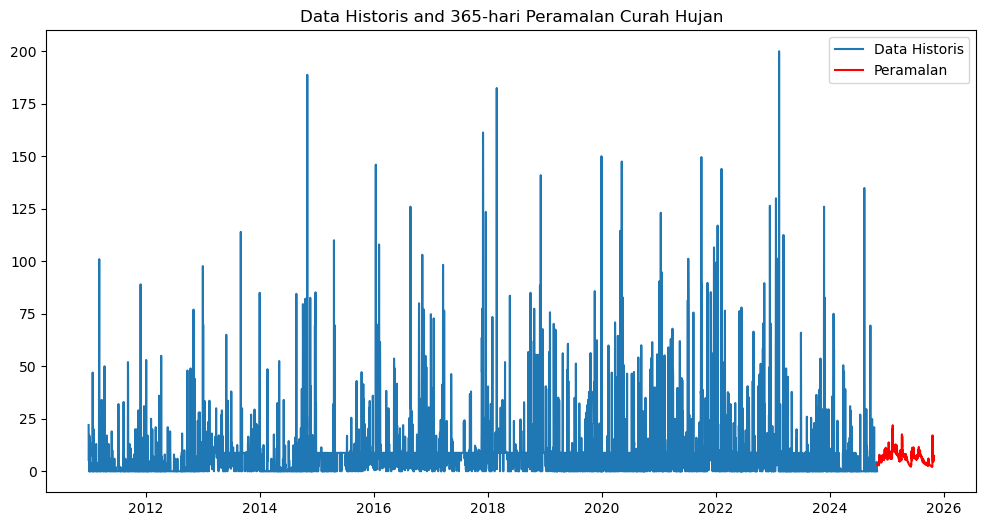

In [34]:
# === Step 6: Visualize Results ===
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast.flatten()})
forecast_df.set_index('Date', inplace=True)

# Combine historical data and forecast
df_combined = pd.concat([df, forecast_df])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['Curah_Hujan'], label='Data Historis')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Peramalan', color='red')
plt.title('Data Historis and 365-hari Peramalan Curah Hujan')
plt.legend()
plt.show()

In [35]:
forecast_df

,Forecast
Date,
2024-11-01,3.261950
2024-11-02,3.093819
2024-11-03,2.960544
2024-11-04,3.231370
2024-11-05,3.084339
...,...
2025-10-27,4.626905
2025-10-28,5.421366
2025-10-29,5.250920


In [36]:
forecast_df.to_csv('D:/cool/TA/data/lstm curah nasa.csv', index=False)

OSError: Cannot save file into a non-existent directory: 'D:\cool\TA\data'

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Define sequence length and features
sequence_length = 10  # Number of time steps in each sequence
num_features = len(df.columns)

# Create sequences and corresponding labels
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(scaled_data) - sequence_length):
        seq = scaled_data[i:i+sequence_length]
        label = scaled_data[i+sequence_length][2]  # column index
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 365  # for 24 hours sequence
sequences, labels = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
train_size = int(0.9 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, 
                               restore_best_weights=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

In [ ]:
# Simple RNN
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Also, 'test_x' and 'test_y' should be available

# Predict temperatures using the trained model
predictions = model.predict(test_x)

# Calculate evaluation metrics 90:10
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Curah Hujan Prediction vs Actual 90:10')
plt.xlabel('Time')
plt.ylabel('Curah Hujan')
plt.legend()
plt.show()

In [ ]:
epsilon = 0.01  # Nilai kecil untuk mengurangi sensitivitas terhadap nilai kecil
MAPE_modified = np.mean(np.abs((test_y - predictions) / (test_y + epsilon))) * 100
print("MAPE Modified:", MAPE_modified)